In [24]:
import yfinance as yf
import pandas as pd
import numpy as np

# Download data
nasdaq_100_Stocks = [
    "AAPL", "ABNB", "ADBE", "ADI", "ADP", "ADSK", "AEP", "AMAT", "AMD", "AMGN",
    "AMZN", "APP", "ARM", "ASML", "AVGO", "AXON", "AZN", "BIIB", "BKNG", "BKR",
    "CCEP", "CDNS", "CDW", "CEG", "CHTR", "CMCSA", "COST", "CPRT", "CRWD", "CSCO",
    "CSGP", "CSX", "CTAS", "CTSH", "DASH", "DDOG", "DXCM", "EA", "EXC", "FANG",
    "FAST", "FTNT", "GEHC", "GFS", "GILD", "GOOG", "GOOGL", "HON", "IDXX", "INTC",
    "INTU", "ISRG", "KDP", "KHC", "KLAC", "LIN", "LRCX", "LULU", "MAR", "MCHP",
    "MDLZ", "MELI", "META", "MNST", "MRVL", "MSFT", "MSTR", "MU", "NFLX", "NVDA",
    "NXPI", "ODFL", "ON", "ORLY", "PANW", "PAYX", "PCAR", "PDD", "PEP", "PLTR",
    "PYPL", "QCOM", "REGN", "ROP", "ROST", "SBUX", "SHOP", "SNPS", "TEAM", "TMUS",
    "TSLA", "TTD", "TTWO", "TXN", "VRSK", "VRTX", "WBD", "WDAY", "XEL", "ZS"
]
start_date = "2022-01-02"
end_date = "2024-12-31"

df = yf.download(nasdaq_100_Stocks, start=start_date, end=end_date, auto_adjust=True)
close_prices = df['Close']

# Calculate Daily Return
daily_return = close_prices.pct_change()

# Calculate Weekly Return
weekly_returns = close_prices.resample('W-FRI').last().pct_change()

# Calculate Volatility (7-days & 21-days)
volatility_7d = daily_return.rolling(window=7).std()
volatility_21d = daily_return.rolling(window=21).std()

# Calculate Cumulative Return
cumulative_return = (1 + daily_return).cumprod()


# DataSet
final_df = pd.DataFrame()
for stock in close_prices.columns:

    stock_data = pd.DataFrame({
        'Date': close_prices.index,
        'Stock': stock,
        'Close_prices': close_prices[stock]. round(4),
        'Daily Return': daily_return[stock].round(4),
        'Weekly Return': weekly_returns[stock].reindex(close_prices.index, method='ffill').round(4),
        'Volatility 7d': volatility_7d[stock].round(4),
        'Volatility 21d': volatility_21d[stock].round(4),
        'Cumulative Return': cumulative_return[stock].round(4)
    })

# Calculate Annualized Return:
    start_price = stock_data['Close_prices'].dropna().iloc[0]
    end_price = stock_data['Close_prices'].dropna().iloc[-1]
    num_days = stock_data['Close_prices'].dropna().count()
    if num_days > 0:
        annualized = (end_price / start_price) ** (252 / num_days) - 1
    else:
        annualized = np.nan

    stock_data['Annualized Return'] = round(annualized, 4)

    final_df = pd.concat([final_df, stock_data])

final_df = final_df.fillna(method="ffill").fillna(method="bfill")
final_df.to_csv("nasdaq100_data.csv", index=False)

[*********************100%***********************]  100 of 100 completed
/tmp/ipython-input-276135316.py:66: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  final_df = final_df.fillna(method="ffill").fillna(method="bfill")


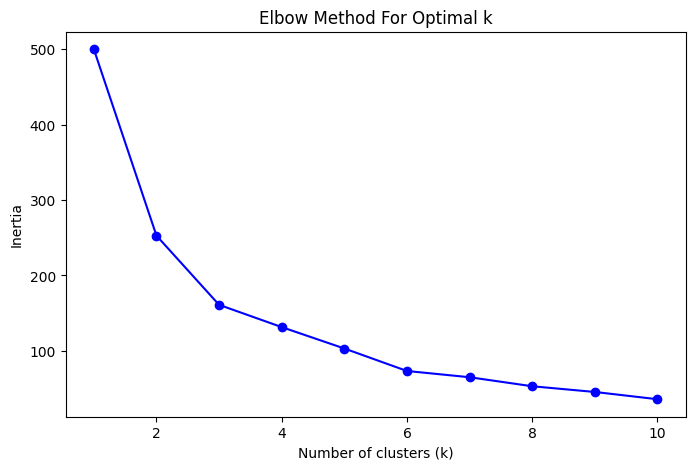

In [15]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Select features for clustering
features = final_df[['Daily Return', 'Weekly Return', 'Volatility 7d', 'Volatility 21d', 'Annualized Return']]
features_per_stock = features.groupby(final_df['Stock']).mean()

# Scale features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_per_stock)


inertia = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled)
    inertia.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(8,5))
plt.plot(K_range, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()


 Cluster Profiles:
          Daily Return  Weekly Return  Volatility 7d  Volatility 21d  \
Cluster                                                               
0              0.0004         0.0025         0.0150          0.0159   
1              0.0010         0.0047         0.0312          0.0335   
2             -0.0001         0.0003         0.0243          0.0253   
3              0.0027         0.0147         0.0340          0.0358   

         Annualized Return  
Cluster                     
0                   0.0851  
1                   0.1312  
2                  -0.0782  
3                   0.6440  

 Clustered Data Preview:

       Daily Return  Weekly Return  Volatility 7d  Volatility 21d  \
Stock                                                               
AAPL       0.000594       0.003150       0.015461        0.016315   
ABNB       0.000049       0.000199       0.026529        0.027230   
ADBE      -0.000045       0.000375       0.021388        0.022626   
ADI   

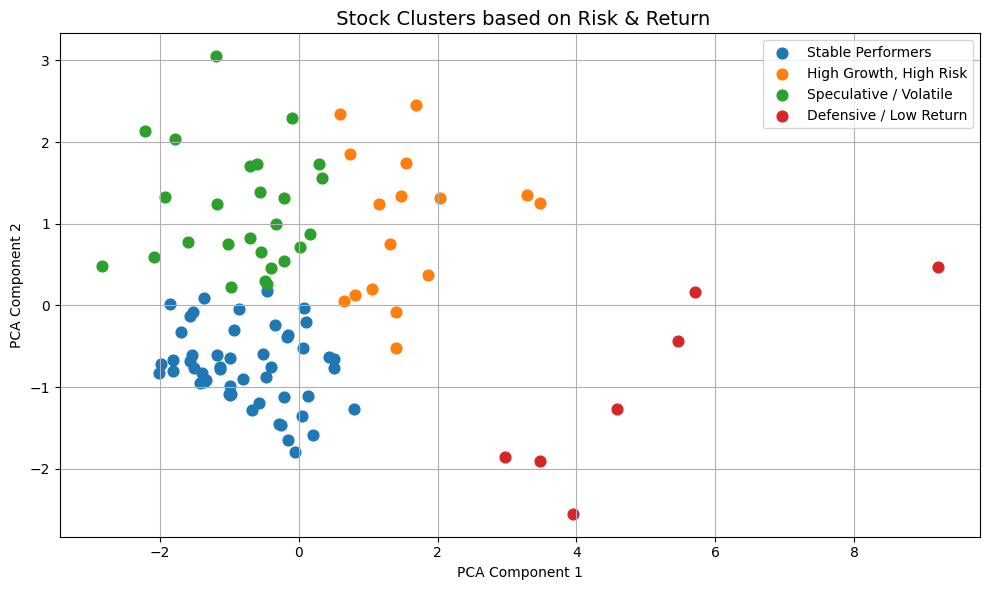

In [23]:
from sklearn.decomposition import PCA

# Make sure features_per_stock exists
features = ['Daily Return', 'Weekly Return', 'Volatility 7d', 'Volatility 21d', 'Annualized Return']
features_per_stock = final_df.groupby('Stock')[features].mean()  # should be run earlier

# Define features to cluster
X = features_per_stock[features].dropna()  # remove NaNs to avoid fit errors

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#KMeans clustering (k=4 from the Elbow Method)
k = 4
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# Align clusters with the same index as X
features_per_stock = features_per_stock.loc[X.index]
features_per_stock['Cluster'] = clusters

# View average characteristics per cluster
cluster_profiles = features_per_stock.groupby('Cluster')[features].mean().round(4)
print("\n Cluster Profiles:\n", cluster_profiles)

# Assign the Clusters Names
cluster_names = {
    0: "Stable Performers",
    1: "High Growth, High Risk",
    2: "Speculative / Volatile",
    3: "Defensive / Low Return"
}
features_per_stock['Cluster Name'] = features_per_stock['Cluster'].map(cluster_names)

# Preview the output
print("\n Clustered Data Preview:\n")
print(features_per_stock[features + ['Cluster', 'Cluster Name']].head())

# PCA Visualization
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_scaled)
features_per_stock['PCA1'] = pca_components[:, 0]
features_per_stock['PCA2'] = pca_components[:, 1]

# Plot
plt.figure(figsize=(10, 6))
for label in sorted(features_per_stock['Cluster'].unique()):
    subset = features_per_stock[features_per_stock['Cluster'] == label]
    plt.scatter(subset['PCA1'], subset['PCA2'], label=cluster_names[label], s=60)

plt.title(' Stock Clusters based on Risk & Return', fontsize=14)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
Final_data = final_df.sort_values('Date').groupby('Stock').tail(1)

# Select clustering features
features = ['Daily Return', 'Weekly Return', 'Volatility 7d', 'Volatility 21d', 'Annualized Return']
X = Final_data[features]

# KMeans clustering with 4 clusters
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
Final_data['Cluster'] = kmeans.fit_predict(X)

# Rename clusters
cluster_names = {
    0: 'High Growth, High Risk',
    1: 'Stable Performers',
    2: 'Volatile Low Return',
    3: 'Moderate Growth'
}
Final_data['Cluster Name'] = Final_data['Cluster'].map(cluster_names)

# Final table
cluster_table = Final_data[['Stock', 'Daily Return', 'Weekly Return', 'Volatility 7d', 'Volatility 21d', 'Annualized Return', 'Cluster Name']]

# Save to Excel
cluster_table.to_csv("stock_clusters.csv", index=False)

In [25]:
import ipywidgets as widgets
from IPython.display import display, clear_output

#  Widgets
stock_dropdown = widgets.Dropdown(
    options=features_per_stock.index.tolist(),
    description="Stock:"
)
amount_input = widgets.FloatText(value=1000, description="Investment ($):")
days_input = widgets.IntSlider(value=252, min=30, max=1000, step=30, description="Days:")

simulate_button = widgets.Button(description="Run Simulation", button_style='success')
output_area = widgets.Output()

#Simulation Function
def simulate(stock, amount, days):
    # Get stock data
    stock_data = final_df[final_df['Stock'] == stock].dropna()
    if stock_data.empty:
        return f"No data available for {stock}"

    annual_return = stock_data['Annualized Return'].iloc[0]
    cluster = features_per_stock.loc[stock, 'Cluster Name']

    # Expected return calculation
    expected_return = amount * ((1 + annual_return) ** (days / 252) - 1)
    future_value = amount + expected_return

    result = (
        f" Stock: {stock}\n"
        f" Cluster: {cluster}\n"
        f" Investment: ${amount:,.2f}\n"
        f" Duration: {days} days\n\n"
        f" Expected Return: ${expected_return:,.2f}\n"
        f" Future Value: ${future_value:,.2f}"
    )
    return result

# Button Action
def on_button_click(b):
    with output_area:
        clear_output()
        result = simulate(stock_dropdown.value, amount_input.value, days_input.value)
        print(result)

simulate_button.on_click(on_button_click)

#Display
display(stock_dropdown, amount_input, days_input, simulate_button, output_area)


Dropdown(description='Stock:', options=('AAPL', 'ABNB', 'ADBE', 'ADI', 'ADP', 'ADSK', 'AEP', 'AMAT', 'AMD', 'A…

FloatText(value=1000.0, description='Investment ($):')

IntSlider(value=252, description='Days:', max=1000, min=30, step=30)

Button(button_style='success', description='Run Simulation', style=ButtonStyle())

Output()

 Stock: AAPL
 Cluster: Stable Performers
 Investment: $10.00
 Duration: 180 days

 Expected Return: $0.85
 Future Value: $10.85
